In [1]:
%matplotlib inline
# packages to load 
# Check the versions of libraries
# Python version
import warnings
warnings.filterwarnings('ignore')
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

# Importing metrics for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import random as rn
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras import initializers

import math

TRAIN_FILE_PATH = "data/X_train.csv"
TARGET_FILE_PATH =  "data/y_train.csv"
TEST_FILE_PATH = "data/X_test.csv"

seed=42
np.random.seed(seed)
rn.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)



# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



Python: 3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
scipy: 1.0.0


Using TensorFlow backend.


In [2]:
#Load train and test set

train_data = pd.read_csv(TRAIN_FILE_PATH)
train_data.drop("id", axis=1, inplace=True)

Y_train = pd.read_csv(TARGET_FILE_PATH)
Y_train.drop("id", axis=1, inplace = True)

test_data =  pd.read_csv(TEST_FILE_PATH)
id_test = test_data.columns[0]
test_data.drop("id", axis=1, inplace=True)

In [3]:
#Zero mean unit variance for train and test data
def scale_data(train, test):
    
    print("Train shape: ", train.shape)
    print("Test shape: ",test.shape)
    
    scaler = StandardScaler().fit(train, Y_train)
    train = scaler.transform(train)
    test = scaler.transform(test)
   
    return train, test

In [4]:
def make_submission(filename, predictions):
    test_data =  pd.read_csv(TEST_FILE_PATH)
    test_data["y"] = predictions
    test_data[["id", "y"]].to_csv("submissions/"+filename, index= False)

In [5]:
X_train_scaled, X_test_scaled = scale_data(train_data, test_data)

Train shape:  (4800, 1000)
Test shape:  (4100, 1000)


# SMOTE Oversampling

In [30]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier


BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    
    X_resampled, Y_resampled = SMOTE().fit_resample(X, Y)
    
    model = RandomForestClassifier(n_estimators=100, random_state=seed)
    model.fit(X_resampled, Y_resampled)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    print(cur_BMAC)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
#make_submission('nk_smote_rfc.csv', pred)


0.5722222222222223
0.6277777777777778
0.5879629629629629
0.6481481481481483
0.6527777777777778
0.575925925925926
0.5712962962962963
0.5842592592592593
0.6064814814814815
0.5888888888888889
AVG: BMAC score: 0.6016 (+/- 0.0293)


# ADASYN Oversampling

In [29]:
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier

BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    
    X_resampled, Y_resampled = ADASYN().fit_resample(X, Y)
    
    model = RandomForestClassifier(n_estimators=100, random_state=seed)
    model.fit(X_resampled, Y_resampled)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    print(cur_BMAC)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
#make_submission('nk_adasyn_RFC.csv', pred)

0.561111111111111
0.6046296296296296
0.5916666666666667
0.612037037037037
0.6546296296296297
0.6185185185185186
0.6157407407407408
0.5703703703703704
0.6157407407407408
0.5851851851851851
AVG: BMAC score: 0.6030 (+/- 0.0257)


# Balanced Random Forest Classifier

0.6712962962962963
0.6731481481481482
0.6592592592592592
0.6749999999999999
0.7064814814814815
0.7111111111111111
0.65
0.6462962962962963
0.6953703703703704
0.6435185185185186
AVG: BMAC score: 0.6731 (+/- 0.0232)


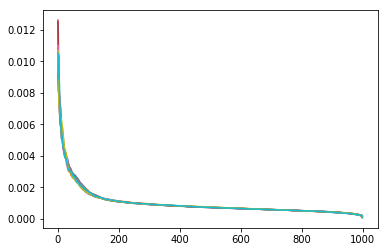

In [33]:
from imblearn.ensemble import BalancedRandomForestClassifier

BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    model = BalancedRandomForestClassifier(n_estimators=100, random_state=seed)
    model.fit(X, Y)
    
    plt.plot((-1*np.sort(-1*np.asarray(model.feature_importances_))))
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Summary of the predictions made by the classifier
    #print(classification_report(X_test, Y_pred))
    #print(confusion_matrix(Y_test, Y_pred))
    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    print(cur_BMAC)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
model.fit(X_train_scaled, Y_train.values) # train on all data
pred = model.predict(X_test_scaled)
#make_submission('nk_balanced_random_forest_classifier.csv', pred)

# Balanced Bagging Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier


BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=seed), 
                                      sampling_strategy='auto',
                                      replacement=False,
                                      random_state=seed)
    model.fit(X, Y)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    print(cur_BMAC)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
#make_submission('nk_balanced_bagging_classifier.csv', pred)

0.5814814814814815
0.6759259259259259
0.639814814814815
0.6666666666666666
0.6407407407407407
0.625
0.6203703703703703
0.6157407407407408
0.6499999999999999
0.6055555555555555
AVG: BMAC score: 0.6321 (+/- 0.0270)


# Easy Ensemble Classifier

In [12]:
from imblearn.ensemble import EasyEnsembleClassifier

BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    model = EasyEnsembleClassifier(random_state=seed)
    model.fit(X, Y)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    print(cur_BMAC)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
#make_submission('nk_easy_ensemble_classifier.csv', pred)

0.6518518518518518
0.650925925925926
0.6842592592592593
0.6768518518518518
0.6898148148148149
0.6638888888888889
0.6250000000000001
0.662962962962963
0.6583333333333333
0.612037037037037
AVG: BMAC score: 0.6576 (+/- 0.0232)


# K-Nearest Neighbours

In [21]:
# K-Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier
BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    model = KNeighborsClassifier(n_neighbors=8)
    model.fit(X, Y)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Summary of the predictions made by the classifier
    #print(classification_report(X_test, Y_pred))
    #print(confusion_matrix(Y_test, Y_pred))
    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
make_submission('ax_knn_8.csv', pred)

Balanced Multi Class Accuracy is 0.5481481481481482
Balanced Multi Class Accuracy is 0.5481481481481482
Balanced Multi Class Accuracy is 0.5675925925925926
Balanced Multi Class Accuracy is 0.5750000000000001
Balanced Multi Class Accuracy is 0.5944444444444444
Balanced Multi Class Accuracy is 0.5805555555555556
Balanced Multi Class Accuracy is 0.5425925925925926
Balanced Multi Class Accuracy is 0.5472222222222222
Balanced Multi Class Accuracy is 0.5907407407407407
Balanced Multi Class Accuracy is 0.5157407407407408
AVG: BMAC score: 0.5610 (+/- 0.0235)


# Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    model = GaussianNB()
    model.fit(X, Y)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Summary of the predictions made by the classifier
    #print(classification_report(X_test, Y_pred))
    #print(confusion_matrix(Y_test, Y_pred))
    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
make_submission('ax_naive_bayes.csv', pred)

Balanced Multi Class Accuracy is 0.575925925925926
Balanced Multi Class Accuracy is 0.6388888888888888
Balanced Multi Class Accuracy is 0.6055555555555556
Balanced Multi Class Accuracy is 0.6175925925925926
Balanced Multi Class Accuracy is 0.6166666666666667
Balanced Multi Class Accuracy is 0.6694444444444444
Balanced Multi Class Accuracy is 0.5953703703703704
Balanced Multi Class Accuracy is 0.5638888888888889
Balanced Multi Class Accuracy is 0.6092592592592593
Balanced Multi Class Accuracy is 0.6277777777777778
AVG: BMAC score: 0.6120 (+/- 0.0288)


# Support Vector Machine

In [28]:
from sklearn.svm import SVC
BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    model = SVC()
    model.fit(X, Y)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Summary of the predictions made by the classifier
    #print(classification_report(X_test, Y_pred))
    #print(confusion_matrix(Y_test, Y_pred))
    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
make_submission('ax_SVC.csv', pred)

AVG: BMAC score: 0.5726 (+/- 0.0234)


# MLP Classifier

In [30]:
from sklearn.neural_network import MLPClassifier
BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    model = MLPClassifier()
    model.fit(X, Y)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Summary of the predictions made by the classifier
    #print(classification_report(X_test, Y_pred))
    #print(confusion_matrix(Y_test, Y_pred))
    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
make_submission('ax_MLP.csv', pred)

AVG: BMAC score: 0.6327 (+/- 0.0214)


# RandomForestClassifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
BMAC = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = Y_train.values[train]
    model = RandomForestClassifier()
    model.fit(X, Y)
    
    X_test = X_train_scaled[test]
    Y_true = Y_train.values[test]
    Y_pred = model.predict(X_test)

    # Summary of the predictions made by the classifier
    #print(classification_report(X_test, Y_pred))
    #print(confusion_matrix(Y_test, Y_pred))
    # Accuracy score
    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
make_submission('ax_RFC.csv', pred)

AVG: BMAC score: 0.5089 (+/- 0.0234)


# AX SOFTMAX TO be continued

In [50]:
BMAC = []



# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train.values)
encoded_Y = encoder.transform(Y_train.values)

num_epochs = 100
def bmac_metric(Y_true, Y_pred):
    TPR =  tf.metrics.recall(Y_true, Y_pred)
    #SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return TPR


# define baseline model
def baseline_model():
    # create model
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    nn = Sequential()
    nn.add(Dense(20, input_dim=1000, activation='relu'))
    nn.add(Dense(3, activation='softmax'))
    # Compile model
    nn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    nn.summary()
    return nn



kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(X_train_scaled, Y_train.values):
    X = X_train_scaled[train]
    Y = encoded_Y[train]
    
    
    model = baseline_model()
    # Fit the model
    model.fit(x=X, y=Y, epochs=num_epochs, verbose=1, validation_split=0.05, shuffle=True, 
              steps_per_epoch=100, initial_epoch=0, validation_steps=5)
    
    X_test = X_train_scaled[test]
    Y_true = encoded_Y[test]
    Y_pred = model.predict(X_test)

    cur_BMAC = balanced_accuracy_score(Y_true, Y_pred)
    BMAC.append(cur_BMAC)
    
print("AVG: BMAC score: %.4f (+/- %.4f)" % (np.mean(BMAC), np.std(BMAC)))
pred = model.predict(X_test_scaled)
make_submission('ax_SOFTMAX.csv', pred)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 20)                20020     
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 63        
Total params: 20,083
Trainable params: 20,083
Non-trainable params: 0
_________________________________________________________________


ValueError: Error when checking target: expected dense_28 to have shape (3,) but got array with shape (1,)

Min val: 0.587761640548706
Last val: 0.5599937438964844


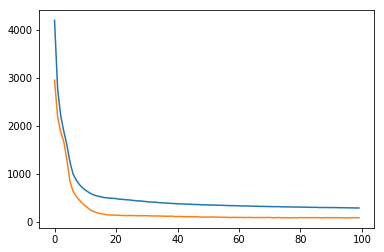

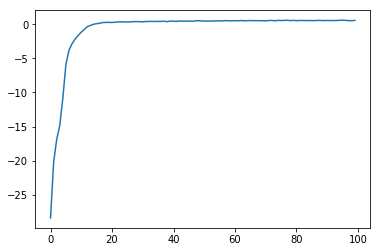

In [59]:
# visualizing losses and accuracy
train_loss = seqModel.history['loss']
val_loss   = seqModel.history['val_loss']
val_coeff_determination  = seqModel.history['val_coeff_determination']
xc         = range(num_epochs)

#Min val: 0.6423026919364929
# Last val: 0.6423026919364929

plt.plot(xc, train_loss);
plt.plot(xc, val_loss);
print("Min val: {}".format(np.max(val_coeff_determination)))
print("Last val: {}".format(val_coeff_determination[-1]))
plt.figure()
plt.plot(xc, val_coeff_determination);


In [37]:
#Predict on test set
predictions = model.predict(X_test_subset)


[[75.78825 ]
 [70.791016]
 [68.12141 ]
 [68.40366 ]
 [70.90145 ]
 [67.24303 ]
 [79.989746]
 [67.714905]
 [73.310234]
 [61.786804]
 [70.027466]
 [65.72696 ]
 [66.06811 ]
 [68.88675 ]
 [70.32245 ]
 [70.204704]
 [63.88546 ]
 [75.380486]
 [64.41486 ]
 [65.89705 ]
 [64.376076]
 [64.54071 ]
 [74.26534 ]
 [65.60742 ]
 [68.51535 ]
 [61.292053]
 [62.33145 ]
 [77.72175 ]
 [81.9335  ]
 [70.76523 ]
 [58.589523]
 [64.5142  ]
 [61.78582 ]
 [65.542755]
 [64.9394  ]
 [68.99081 ]
 [73.154755]
 [61.32441 ]
 [67.86541 ]
 [71.84517 ]
 [68.860954]
 [69.87808 ]
 [66.667015]
 [68.91196 ]
 [67.56796 ]
 [62.587585]
 [76.55645 ]
 [70.99911 ]
 [71.60235 ]
 [73.02955 ]
 [64.238075]
 [63.801857]
 [61.09562 ]
 [63.93416 ]
 [65.5166  ]
 [67.037   ]
 [79.99452 ]
 [59.48519 ]
 [64.83139 ]
 [68.64711 ]
 [75.97903 ]
 [74.384285]
 [75.972   ]
 [66.33517 ]
 [67.12427 ]
 [69.11149 ]
 [73.11118 ]
 [73.916336]
 [60.436127]
 [64.09543 ]
 [66.59161 ]
 [69.11752 ]
 [77.47893 ]
 [72.57387 ]
 [58.937225]
 [64.86406 ]
 [67.28141 ]

In [38]:
#Prepare predictions to be wirtten to csv
filename = "ax_keras_20.csv"
test_data =  pd.read_csv(TEST_FILE_PATH)
test_data["y"] = predictions
test_data[["id", "y"]].to_csv("submissions/"+filename, index= False)

#print(y_pred)

In [31]:
# load the predictions and try to round them
pred_1 =  pd.read_csv("submissions/best.csv")

def round_function(x):
    frac, whole = math.modf(x)
    lim = 0.1
    # round down 
    if np.abs(frac) < lim:
        return whole
    # round up
    if np.abs(frac) > 1.0 - lim:
        return whole + 1
    return x

pred_1["y"] = pred_1["y"].apply(round_function)
pred_1[["id", "y"]].to_csv("submissions/best_rounded.csv", index= False)

